In [1]:
%matplotlib inline

import torch
import torch.nn as nn
from torchvision import models
import torchvision.transforms as transforms

from PIL import Image
import numpy as np 
import matplotlib.pyplot as plt

import os
import sys

In [2]:
# Define globle parameters

norm_mean = (0.485, 0.456, 0.406)  # Means and variance referenced from ImageNet
norm_std = (0.229, 0.224, 0.225)
denorm_mean = (-2.118, -2.036, -1.804)
denorm_std = (4.367, 4.464, 4.444)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Utility functions for image loading

In [3]:
def load_image(image_fp, shape=None):
    image = Image.open(image_fp)
    while image.width > 512 or image.height > 512:
        image = image.resize((image.width // 2, image.height // 2))
    if shape:
        image = image.resize(shape, Image.LANCZOS)
    return image


def show_image(image):
    plt.axis('off')
    plt.imshow(image)
    plt.show()


def save_image(image, image_fp):
    image.save(image_fp)


def PIL_to_tensor(image):
    image_ = image.copy()
    image_ = transforms.ToTensor()(image_)
    image_ = image_.unsqueeze(0)
    image_ = normalize(image_)
    return image_


def tensor_to_PIL(image):
    image_ = image.clone().detach()
    image_ = denormalize(image_)
    image_ = image_.squeeze()
    image_ = transforms.ToPILImage()(image_)
    return image_


def normalize(image):
    image_ = transforms.Normalize(mean=norm_mean, std=norm_std)(image)
    return image_


def denormalize(image):
    image_ = transforms.Normalize(mean=denorm_mean, std=denorm_std)(image)
    image_ = image_.clamp(0, 1)
    return image_

### Loss functions

In [4]:
def squared_error_loss(x, y):
    '''
    Compute the squared error loss of the input x and y.
    
    Input:
        x, y : (B,H,W,C) torch.float32 tensor from target and style feature maps in layer l
    Output:
        the value of loss
    '''
    b, c, h, w = x.size()
    F_x = x.view(b*c, h*w)
    F_a = y.view(b*c, h*w)
    
    F_a = torch.mm(F_a, F_a.t())  # compute A_l
    F_x = torch.mm(F_x, F_x.t())  # compute G_l
    return torch.mean((F_x - F_a) ** 2) / (4 * c * h * w)


def linear_kernel_loss(x, y):
    '''
    Define the linear feature mapping function of Maximum Mean Discrepancy(MMD) to compute the style loss.
    Based on the linear kernel function of k(x, y) = x.T * y
    
    Input:
        x, y : (B,H,W,C) torch.float32 tensor from target and style feature map in layer l
    Output:
        the value of loss
    '''
    b, c, h, w = x.size()
    x, y = torch.flatten(x), torch.flatten(y)
    d_x = torch.sum(torch.dot(x, x.t()))
    d_y = torch.sum((torch.dot(y, y.t())))
    d_xy = torch.sum((torch.dot(x, y.t())))
    return (d_x + d_y - 2*d_xy) / (4 * c * h * w)


def poly_kernel_loss(x, y, c=2):
    '''
    Define the ploynomial feature mapping function of MMD to compute the style loss.
    Based on the ploynomial kernel function of k(x, y) = (x.T*y + c)^d with d = 2.
    
    Input:
        x, y : (B,H,W,C) torch.float32 tensor from target and style feature map in layer l
    Output:
        the value of loss
    '''
    b, c, h, w = x.size()
    x = x.view(b*c, h*w)
    y = y.view(b*c, h*w)
    
    d_x = (torch.mean(torch.mm(x, x.t())))**2 + 2*c*torch.mean(torch.mm(x, x.t()))
    d_y = (torch.mean(torch.mm(y, y.t())))**2 + 2*c*torch.mean(torch.mm(y, y.t()))
    d_xy = (torch.mean(torch.mm(x, y.t())))**2 + 2*c*torch.mean(torch.mm(x, y.t()))
    return (d_x + d_y - 2*d_xy) / (4 * c * h * w)

### Style transfer implementation

In [5]:
class VGG(nn.Module):
    '''
    Class for instante a pre-trained VGG-19 model and extract features from the intermediate layers.
        
    '''
    def __init__(self):
        super().__init__()
        # Load VGG19 features
        self.vgg = models.vgg19(pretrained=True).features  # VGG19 will be downloaded to your computer automatically
        # We focus only on these layers
        self.select = {
            '0': 'conv1_1',   # style layer
            '5': 'conv2_1',   # style layer
            '10': 'conv3_1',  # style layer
            '19': 'conv4_1',  # style layer
            '28': 'conv5_1',  # style layer
            '21': 'conv4_2'   # content layer
        }
        # Avoid to train VGG
        for param in self.vgg.parameters():
            param.requires_grad_(False)

    def forward(self, x):
        features = {}
        for name, layer in self.vgg._modules.items():
            x = layer(x)
            if name in self.select:
                features[self.select[name]] = x
        return features

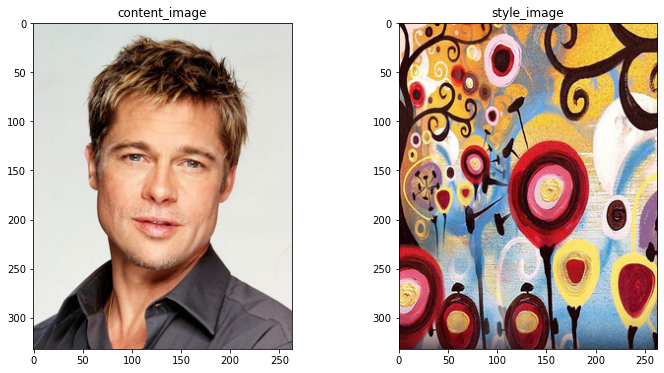

In [16]:
# Load content and style images
p = load_image("imgs/content.jpg")         # p refers to content image
a = load_image("imgs/style.jpg", p.size)   # a refers to style image

p = PIL_to_tensor(p).to(device)
a = PIL_to_tensor(a).to(device)

# Show images
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.title('content_image')
plt.imshow(tensor_to_PIL(p))
plt.subplot(122)
plt.imshow(tensor_to_PIL(a))
plt.title('style_image')
plt.show()

# p.size(), a.size()

In [17]:
# Inicialize our target image x
x = p.clone().requires_grad_(True).to(device)             # x refers to the target image that we want to optimize
# x = torch.ones_like(p).requires_grad_(True).to(device)

# Get features from VGG
vgg = VGG().to(device).eval()

### Variables set up for training

In [18]:
# Inicialize parameters
style_weights = {
     'conv1_1': 0.1,
     'conv2_1': 0.2,
     'conv3_1': 0.4,
     'conv4_1': 0.8,
     'conv5_1': 1.6
}

content_weight = 2
style_weight = 1

optimizer = torch.optim.Adam([x], lr=0.5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.9)
total_step = 2000

content_loss_lst = []
style_loss_lst = []
total_loss_lst = []

### Train model

Step 0/2000, Total loss:280.0247, Content Loss: 0.0000, Style Loss: 280.0247
Step 100/2000, Total loss:34.2694, Content Loss: 19.1680, Style Loss: 15.1014
Step 200/2000, Total loss:33.8058, Content Loss: 18.4992, Style Loss: 15.3066
Step 300/2000, Total loss:32.8128, Content Loss: 19.6329, Style Loss: 13.1799
Step 400/2000, Total loss:34.2106, Content Loss: 15.7821, Style Loss: 18.4285
Step 500/2000, Total loss:28.4803, Content Loss: 16.5889, Style Loss: 11.8915
Step 600/2000, Total loss:34.0450, Content Loss: 14.8839, Style Loss: 19.1611
Step 700/2000, Total loss:28.7396, Content Loss: 16.3992, Style Loss: 12.3404
Step 800/2000, Total loss:28.4698, Content Loss: 16.6077, Style Loss: 11.8620
Step 900/2000, Total loss:26.9422, Content Loss: 15.8555, Style Loss: 11.0867
Step 1000/2000, Total loss:28.3014, Content Loss: 15.2352, Style Loss: 13.0663
Step 1100/2000, Total loss:26.0932, Content Loss: 15.5705, Style Loss: 10.5228
Step 1200/2000, Total loss:28.5141, Content Loss: 17.1205, Styl

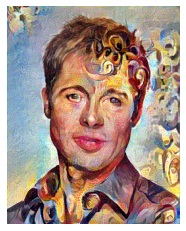

Wall time: 52.9 s


In [19]:
%%time
for step in range(total_step):
    
    layers_p = vgg(p)    # get content features
    layers_a = vgg(a)    # get style features
    layers_x = vgg(x)    # get target features
    
    # Compute content loss by squared error loss function
    content_loss = 0
    content_loss = torch.mean((layers_x['conv4_2'] - layers_p['conv4_2']) ** 2)

    # Compute style loss
    style_loss = 0
    for l in style_weights:
        # There are three methods to compute the style loss of current layer, you can choose one of them.
        
#         # Method 1: MMD of linear_kernel_loss
#         style_layer_loss = style_weights[l] * linear_kernel_loss(layers_x[l], layers_a[l])

#         # Method 2: MMD of poly_kernel_loss
#         style_layer_loss = style_weights[l] * poly_kernel_loss(layers_x[l], layers_a[l])

        # Method 3: squared_error_loss by defualt
        style_layer_loss = style_weights[l] * squared_error_loss(layers_x[l], layers_a[l])
        
        # Sum of the five layer style loss
        style_loss += style_layer_loss
        
    total_loss = content_weight * content_loss + style_weight * style_loss
    
    # Record the losses for ploting
    total_loss_lst.append(total_loss.item())
    style_loss_lst.append(style_weight * style_loss)
    content_loss_lst.append(content_weight * content_loss.item())
    
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    scheduler.step()

    if step % 100 == 0:
        print('Step {}/{}, Total loss:{:.4f}, Content Loss: {:.4f}, Style Loss: {:.4f}'.
              format(step, total_step, total_loss.item(), content_weight *content_loss, style_weight *style_loss))


x = tensor_to_PIL(x)

show_image(x)
save_image(x, 'target.jpg')

### Plot Loss vs. Iterations

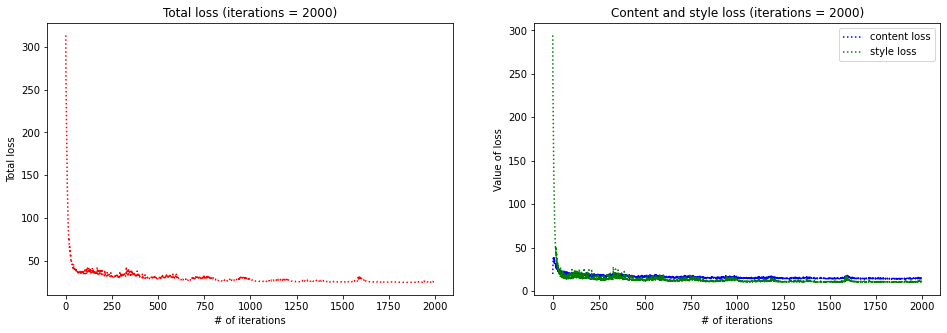

In [20]:
plt.figure(figsize=(16,5))
plt.subplot(121)
plt.plot(total_loss_lst[1:], 'r:', label='total loss')
plt.xlabel("# of iterations")
plt.ylabel("Total loss")
plt.title('Total loss (iterations = %i)'%total_step)

plt.subplot(122)
plt.plot(content_loss_lst[1:], 'b:', label='content loss')
plt.plot(style_loss_lst[1:], 'g:', label='style loss')
plt.xlabel("# of iterations")
plt.ylabel("Value of loss")
plt.title('Content and style loss (iterations = %i)'%total_step)
plt.legend()
plt.show()